In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rrebirrth_animals_with_attributes_2_path = kagglehub.dataset_download('rrebirrth/animals-with-attributes-2')

print('Data source import complete.')


100%|██████████| 13.0G/13.0G [07:03<00:00, 32.9MB/s]

Extracting files...


Data source import complete.


# 1. Gerekli Kütüphanelerin Yüklenmesi


In [2]:
# Gerekli kütüphaneleri yükleme
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# 2. Veri Setinin Hazırlanması
## 2.1 Sınıfların Seçimi ve Dengelenmesi

In [3]:
# Veri seti klasörlerinin yolları
source_dir = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/"
target_dir = "/content/FilteredImages"  # Filtrelenmiş veri seti kaydedileceği yol

# Kullanılacak sınıflar
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650

# Veriyi filtreleme ve yeni klasöre kopyalama
os.makedirs(target_dir, exist_ok=True)
for class_name in selected_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(target_dir, class_name)
    os.makedirs(target_path, exist_ok=True)
    for i, file_name in enumerate(os.listdir(class_path)):
        if i >= images_per_class:
            break
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name):
            cv2.imwrite(os.path.join(target_path, file_name), cv2.imread(full_file_name))
print("Veri seti hazırlandı ve dengelendi.")


Veri seti hazırlandı ve dengelendi.


## 2.2 Görüntülerin Boyutlandırılması ve Normalizasyonu

In [4]:
# Görüntülerin işlenmesi (128x128 boyutlandırma ve normalizasyon)
def load_and_process_images(data_dir, image_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                img = cv2.imread(file_path)
                if img is not None:
                    img_resized = cv2.resize(img, image_size)
                    img_normalized = img_resized / 255.0
                    images.append(img_normalized)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

data_dir = target_dir
X, y = load_and_process_images(data_dir)
print(f"Veri kümesi boyutu: {X.shape}")


Veri kümesi boyutu: (6500, 128, 128, 3)


## 2.3 Verilerin Eğitim ve Test Seti Olarak Ayrılması

In [5]:
# Etiketlerin dönüştürülmesi
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Veriyi bölme (%70 eğitim, %30 test)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
print(f"Eğitim veri boyutu: {X_train.shape}, Test veri boyutu: {X_test.shape}")


Eğitim veri boyutu: (4550, 128, 128, 3), Test veri boyutu: (1950, 128, 128, 3)


# 3. Veri Artırımı (Augmentation)


In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CLAHE ile kontrast artırma
def adjust_contrast(img):
    import cv2
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Görüntülerin veri tipi ve değer aralığını kontrol et
    if img.dtype != np.uint8:  # CLAHE yalnızca uint8 ile çalışır
        img = (img * 255).astype(np.uint8)  # Normalize edilen görüntüyü 0-255 aralığına taşı ve uint8 yap

    # RGB görüntü için her kanalda CLAHE uygula
    if len(img.shape) == 3:  # Renkli görüntüler (3 kanal)
        for i in range(3):
            img[..., i] = clahe.apply(img[..., i])
    else:  # Gri tonlamalı görüntüler
        img = clahe.apply(img)

    return img

# Gürültü ekleme fonksiyonu
def add_gaussian_noise(img, mean=0, std=0.1):
    noise = np.random.normal(mean, std, img.shape)
    img_noisy = img + noise
    return np.clip(img_noisy, 0, 1)  # Gürültü eklenmiş görüntü

# Veri artırma işlemleri için ImageDataGenerator oluşturma
datagen = ImageDataGenerator(
    brightness_range=[0.8, 1.2],  # Parlaklık artırma/düşürme
    preprocessing_function=add_gaussian_noise,  # Gürültü ekleme fonksiyonu
    rotation_range=20,  # Döndürme (0-20 derece arasında)
    width_shift_range=0.2,  # Genişlik kaydırma
    height_shift_range=0.2,  # Yükseklik kaydırma
    zoom_range=0.2,  # Yakınlaştırma/uzaklaştırma
    horizontal_flip=True,  # Yatay çevirme
    fill_mode='nearest'  # Boş alanları doldurma yöntemi
)

# Örnek veri seti oluştur
X_sample = np.random.random((10, 128, 128, 3))  # 10 tane 128x128 boyutunda rastgele RGB görüntü (0-1 arasında)
y_sample = np.random.randint(0, 10, 10)  # Örnek etiketler (10 sınıf)

# Veri artırmayı uygula
generator = datagen.flow(X_sample, y_sample, batch_size=2)

# İlk batch çıktısını incele
for X_batch, y_batch in generator:
    print(f"Augmented batch shape: {X_batch.shape}")
    break  # Bir batch göster


Augmented batch shape: (2, 128, 128, 3)


# 4. CNN Modelinin Oluşturulması

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,550,602 (24.99 MB)

 Trainable params: 6,550,410 (24.99 MB)

 Non-trainable params: 192 (768.00 B)

# 5. Modelin Eğitilmesi

In [8]:
# Modeli derleme
model.compile(
    optimizer='adam',               # Optimizasyon algoritması
    loss='categorical_crossentropy', # Kayıp fonksiyonu
    metrics=['accuracy']            # Değerlendirme metriği
)

# Veri artırma (Data Augmentation)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Eğitim ve doğrulama jeneratörleri
train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_test, y_test, batch_size=32)

# steps_per_epoch ve validation_steps hesaplama
steps_per_epoch = len(X_train) // 32
validation_steps = len(X_test) // 32

# Modeli eğitme
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.1835 - loss: 3.6727 - val_accuracy: 0.1115 - val_loss: 3.1316
Epoch 2/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 6:03 3s/step - accuracy: 0.3750 - loss: 1.9607

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3750 - loss: 1.9607 - val_accuracy: 0.1000 - val_loss: 3.5262
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.3201 - loss: 1.9137 - val_accuracy: 0.1802 - val_loss: 2.9131
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3750 - loss: 1.7172 - val_accuracy: 0.2000 - val_loss: 3.2786
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.3828 - loss: 1.7756 - val_accuracy: 0.2958 - val_loss: 2.0142
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.4688 - loss: 1.5765 - val_accuracy: 0.4333 - val_loss: 1.5642
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.4182 - loss: 1.6734 - val_accuracy: 0.4328 - val_loss: 1.7184
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5000 - loss: 1.4954 - val_accuracy: 0.3667 - val_loss: 1.7478
Epoch 9/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.4600 - loss: 1.5730 - val_accuracy: 0.4635 

# 6. Modelin Test Edilmesi

In [9]:
# Test doğruluğunu değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")


61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.5461 - loss: 1.3395
Test Doğruluğu: 55.18%


# 7. Manipüle Edilmiş Test Seti

In [10]:
# Görüntü manipülasyonu (örneğin parlaklık artırma)
def manipulate_images(images):
    manipulated_images = []
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=1.5, beta=30)  # Parlaklık artırma
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

X_test_manipulated = manipulate_images(X_test)
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipüle Edilmiş Test Doğruluğu: {manipulated_accuracy * 100:.2f}%")


61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.1059 - loss: 297.3365
Manipüle Edilmiş Test Doğruluğu: 10.36%


# 8. Renk Sabitliği (Gray World Algoritması)


In [11]:
def apply_gray_world(image):
    avg_b, avg_g, avg_r = cv2.mean(image)[:3]
    gray_value = (avg_b + avg_g + avg_r) / 3
    scaling_factors = np.array([gray_value / avg_b, gray_value / avg_g, gray_value / avg_r])
    corrected_image = image * scaling_factors  # Her kanal için ayrı ölçekleme
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image
# Manipüle edilmiş test setine renk sabitliği uygulama
X_test_corrected = np.array([apply_gray_world(img) for img in X_test_manipulated])

# Modeli renk sabitliği uygulanmış test setiyle değerlendirme
corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test)
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu: {corrected_accuracy * 100:.2f}%")


61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.1059 - loss: 287.0139
Renk Sabitliği Uygulanmış Test Doğruluğu: 10.36%


# 9. Sonuçların Karşılaştırılması

In [12]:
# Eğitim ve doğrulama doğruluğu sonuçlarını hesaplama
train_accuracy = history.history['accuracy'][-1]  # Son epoch'daki eğitim doğruluğu
val_accuracy = history.history['val_accuracy'][-1]  # Son epoch'daki doğrulama doğruluğu

# Test sonuçlarının karşılaştırılması
print("Sonuçlar:")
print(f"Orijinal Test Seti Doğruluğu: {test_accuracy * 100:.2f}%")
print(f"Manipüle Edilmiş Test Seti Doğruluğu: {manipulated_accuracy * 100:.2f}%")
print(f"Renk Sabitliği Uygulanmış Test Seti Doğruluğu: {corrected_accuracy * 100:.2f}%")
print(f"Eğitim Doğruluğu: {train_accuracy * 100:.2f}%")
print(f"Doğrulama Doğruluğu: {val_accuracy * 100:.2f}%")


Sonuçlar:
Orijinal Test Seti Doğruluğu: 55.18%
Manipüle Edilmiş Test Seti Doğruluğu: 10.36%
Renk Sabitliği Uygulanmış Test Seti Doğruluğu: 10.36%
Eğitim Doğruluğu: 71.88%
Doğrulama Doğruluğu: 43.33%


# Eğitim ve doğrulama doğruluğu graafiği

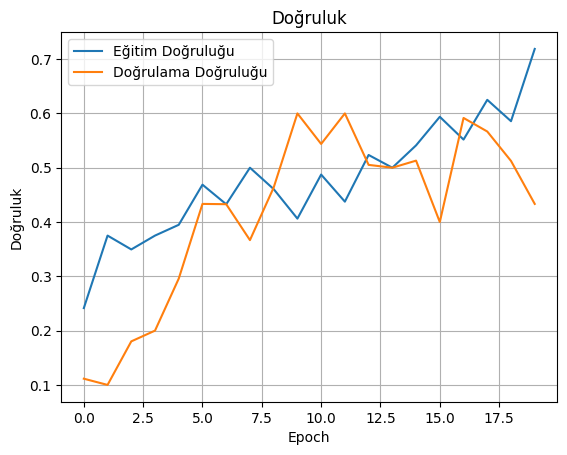

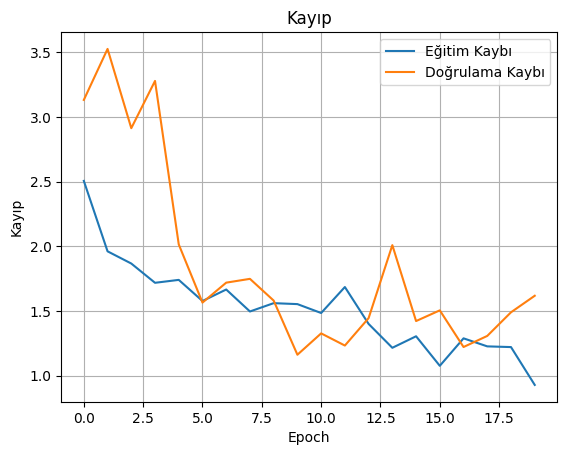

In [13]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu grafiği
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Doğruluk')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid(True)
    plt.show()

# Eğitim ve doğrulama kaybı grafiği
def plot_loss(history):
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True)
    plt.show()

# Grafikleri çiz
plot_accuracy(history)  # 'history' model eğitimi sırasında elde edilen sonuçları içeren değişken
plot_loss(history)
